<a href="https://colab.research.google.com/github/haosulab/ManiSkill2/blob/tutorials/examples/tutorials/1_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code

To begin, prepare the colab environment by clicking the play button below. This will install all dependencies for the future code.

In [ ]:
!apt-get install -y --no-install-recommends libvulkan-dev
!pip install "setuptools>=62.3.0"
!pip install -v git+https://github.com/haosulab/ManiSkill2.git@tutorials
!pip uninstall -y pathlib  # avoid overriding the builtin one

# !pip install sapien gym==0.21.0 pyyaml tabulate tqdm h5py transforms3d opencv-python imageio imageio[ffmpeg] trimesh open3d rtree GitPython
!pip uninstall -y sapien && pip install https://anaconda.org/jigu/sapien/2.0.0.dev20230112/download/sapien-2.0.0.dev20230112-cp38-cp38-manylinux2014_x86_64.whl
!cd ManiSkill2 && python setup.py develop

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

# Maniskill Environments and Demonstrations Tutorial

This notebook goes over how to create and configure environments as well as work with our demonstration dataset. Our [ManiSkill](https://github.com/haosulab/ManiSkill2) environments follows the `gym` api with various robotics related customizations and demonstration dataset that enable research into different areas such as robotics, computer vision, and reinforcement learning. The environments are built on top of the [Sapien](sapien.ucsd.edu/) simulation environment.

This tutorial will work with the PickCube environment, a simple but also commonplace robotics task.

In [3]:
# Import required packages
import gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill2.envs
import matplotlib.pyplot as plt

## 1 Create and configure environments

We can create ManiSkill environments by specifying a environment id. Further, observations, actions, and rewards are configurable with just a few lines of code

Action Space: Box([-1. -1. -1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1.], (8,), float32)


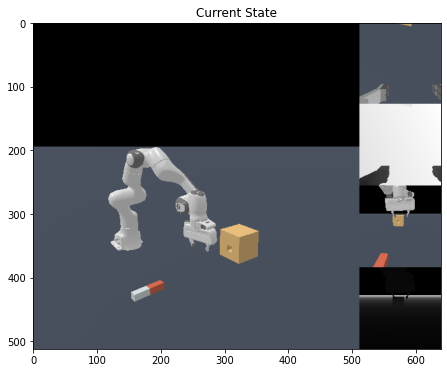

In [21]:
#@title Choose an environment, observation mode, control mode, and reward

# Can be any env_id from the list of Rigid-Body envs: https://github.com/haosulab/ManiSkill2/wiki/Rigid-Body-Environments
# and Soft-Body envs: https://github.com/haosulab/ManiSkill2/wiki/Soft-Body-Environments
env_id = "PickCube-v0" #@param can be one of ['PickCube-v0', 'PegInsertionSide-v0', 'StackCube-v0', 'PlugCharger-v0']

# choose an observation type and space, see https://github.com/haosulab/ManiSkill2/wiki/Observation-Space for details
obs_mode = "rgbd" #@param can be one of ['pointcloud', 'rgbd', 'state_dict', 'state']

# choose a controller type / action space, see https://github.com/haosulab/ManiSkill2/wiki/Controllers for a full list
control_mode = "pd_joint_delta_pos" #@param can be one of ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param can be one of ['sparse', 'dense']

# create our environment with our configs and then reset to a clean state
env = gym.make(env_id, obs_mode=obs_mode, reward_mode=reward_mode, control_mode=control_mode)
obs = env.reset()
print("Action Space:", env.action_space)
# take a look at the current state
img = env.render(mode="cameras")
plt.figure(figsize=(10,6))
plt.title("Current State")
plt.imshow(img)
env.close()

Run below to further visualize RGBD and Pointcloud observations

In [22]:
# some visualization functions for different observation modes
def show_camera_view(obs_camera, title):
    plt.figure()
    rgb, depth = obs_camera['rgb'], obs_camera['depth']
    plt.subplot(1,2,1)
    plt.title(f"{title} - RGB")
    plt.imshow(rgb)
    plt.subplot(1,2,2)
    plt.title(f"{title} - Depth")
    plt.imshow(depth[:,:, 0], cmap="gray")
def show_pointcloud(obs):
    import trimesh
    v = obs['pointcloud']['xyzw'][::,:3]
    s= trimesh.Scene([trimesh.points.PointCloud(v, obs['pointcloud']['rgb'])])
    return s.show()

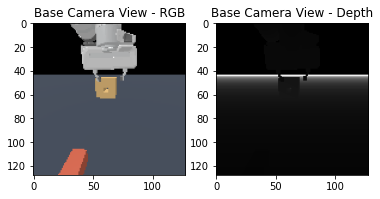

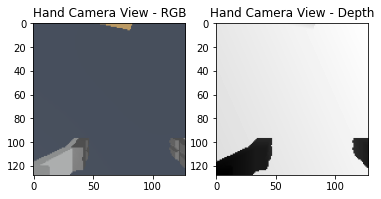

In [23]:
# display the RGBD observation
show_camera_view(obs['image']['base_camera'], "Base Camera View")
show_camera_view(obs['image']['hand_camera'], "Hand Camera View")

In [20]:
# display the Pointcloud observation
show_pointcloud(obs)

### 1.1 Interactive Viewer and Recording videos

ManiSkill has a interactive viewer, available if you have a GUI. You can render the current state with `env.render()` which will bring up a viewer.

To create a replay video of what happened in an episode, we can use the `RecordEpisode` environment wrapper as so, and specify what we want to record. Note that recording replay videos adds some overhead so ensure you don't use this while training.

To try and manually control a robot agent with your keyboard, you can run https://github.com/haosulab/ManiSkill2/blob/main/examples/demo_manual_control.py

In [24]:
from mani_skill2.utils.wrappers import RecordEpisode
env = gym.make(env_id) 
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    render_mode="cameras", # cameras - three camera images + depth images, rgb_array - single camera image
    info_on_video=True # when True, will add informative text onto the replay video such as step counter, reward, and other metrics 
)

# step through the environment with random actions
obs = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if not IN_COLAB: env.render() # will render with a window if possible
env.flush_video() # Save the video
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True) # Watch our replay

  0%|          | 0/100 [00:00<?, ?it/s]

## 2 Using demonstration data

The following code will go through the basic usage of our large-scale robotics demonstration dataset.

Each environment comes with a `.h5` file composed of all the demonstrations. Moreover, each `.h5` file has an associated `.json` file defining the environment configuration used in those demonstrations. Here is how to download and load the demonstrations.

### 2.1 Download and load

We provide a simple command line tool to download demos. Specify an output folder and environment ID and it will download the appropriate demonstrations

In [26]:
# We provide a command line tool to download demonstrations.
!python -m mani_skill2.utils.download_demo {env_id} -o "demos"

Retrieving folder list
Processing file 1w3RS9L5qfFTqmyS6MtEy4kbQVF5JTiKq trajectory.h5
Processing file 1xSM4tEKgVQ3YfrkFu6EFI9h36JRxb6da trajectory.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1w3RS9L5qfFTqmyS6MtEy4kbQVF5JTiKq
To: /content/demos/rigid_body/PegInsertionSide-v0/trajectory.h5
100% 50.6M/50.6M [00:00<00:00, 79.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xSM4tEKgVQ3YfrkFu6EFI9h36JRxb6da
To: /content/demos/rigid_body/PegInsertionSide-v0/trajectory.json
100% 407k/407k [00:00<00:00, 161MB/s]
Download completed


To load the demonstration dataset, we use h5py and a load_json utility

In [29]:
import h5py
from mani_skill2.utils.io_utils import load_json

# Load the trajectory data from the .h5 file
traj_path = f"demos/rigid_body/{env_id}/trajectory.h5"
# You can also replace the above path with the trajectory you just recorded (./tmp/trajectory.h5)
h5_file = h5py.File(traj_path, "r")

# Load associated json
json_path = traj_path.replace(".h5", ".json")
json_data = load_json(json_path)

episodes = json_data["episodes"]  # meta data of each episode
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]

print("env_id:", env_id)
print("env_kwargs:", env_kwargs)
print("#episodes:", len(episodes))

The trajectory of each episode is stored under the `traj_{episode_id}` key in the HDF5 file. `episode_id` usually ranges from 0 to `len(episodes) - 1`.
`episode_id` and other meta information of episdoes are stored under the `episodes` key in the JSON file.
The raw trajectory contains 3 keys: `actions`, `env_states` and `success`. For soft-body environments, `env_states` is replaced by `env_init_state` (initial state) to reduce data storage.

In [30]:
traj_id = "traj_0"
traj_h5 = h5_file[traj_id]
for key in traj_h5:
    print(key, traj_h5[key].shape, traj_h5[key].dtype)

<HDF5 group "/traj_0" (3 members)>
<KeysViewHDF5 ['actions', 'env_states', 'success']>


**Notably, the raw trajectories do not include actual observations.** We store both actions and environment states, which can be used to replay trajectories and generate desired observations (states, RGBD images, point cloud). Please see the following sections for how to replay and convert demonstrations to your desired observation and action spaces.

### 2.2 Replay demonstrations

To replay the trajectory of an episode, you need to first create an environment given the environment initialization keyword arguments stored in the JSON file. Additionally, you need to reset the environment with the same seed and other keyword arguments of the episode recorded in the JSON file. Then, the trajectory can be replayed by actions or environment states stored in the HDF5 file.

In [31]:
def replay(episode_idx, h5_file, json_data, render_mode="cameras", fps=20):
    episodes = json_data["episodes"]
    ep = episodes[episode_idx]
    # episode_id should be the same as episode_idx, unless specified otherwise
    episode_id = ep["episode_id"]
    traj = h5_file[f"traj_{episode_id}"]

    # Create the environment
    env_kwargs = json_data["env_info"]["env_kwargs"]
    env = gym.make(env_id, **env_kwargs)
    # Reset the environment
    reset_kwargs = ep["reset_kwargs"].copy()
    reset_kwargs["seed"] = ep["episode_seed"]
    env.reset(**reset_kwargs)

    frames = [env.render(mode=render_mode)]

    for i in tqdm(range(len(traj["actions"]))):
        action = traj["actions"][i]
        obs, reward, done, info = env.step(action)
        if not IN_COLAB: env.render()
        frames.append(env.render(mode=render_mode))
    
    env.close()
    del env
    return frames

  0%|          | 0/164 [00:00<?, ?it/s]

In [ ]:
from mani_skill2.utils.visualization.jupyter_utils import display_images

episode_idx = 0 #@param {type:"integer"}
frames = replay(episode_idx, h5_file, json_data)
display_images(frames, format="jshtml",  repeat=True, cache_frame_data=False, interval=50)

### 2.3 Convert demonstrations

The demonstration dataset does not include actual observations. You can convert trajectories to the desired observation space and action space. We provide a tool to help replay and convert trajectories.

```python
# Replay the trajectory to `rgbd` observations and the `pd_ee_delta_pose` controller with 10 processes in parallel
python -m mani_skill2.trajectory.replay_trajectory --traj-path demos/rigid_body/PickCube-v0/trajectory.h5 --save-traj --obs-mode rgbd --target-control-mode pd_ee_delta_pose --num-procs 10
```